# Assignment 2: Part 1

First we write a individual based simulation. It is based on the DES algorithm.

In [2]:
# requirements
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as igr
from numba import jit, typed # Use JIT to optimize runtime, since otherwise is very slow

from tqdm.notebook import tqdm, trange

In [5]:
# SIR simulation model, note used frequency dependent model
@jit(nopython=True)
def generate_exponential(rate: float) -> float:
    """Generates random simulation from an exponential distribution

    Args:
        rate (float): Rate of exponential distribution events

    Returns:
        float: Random exponential point
    """
    return -np.log(np.random.random()) / rate

# Use numba for extra speed, cause otherwise it is slow
# Numba achieves a speedup of 10.000x, thus it is very useful
@jit(nopython=True, cache=True)
def simulation_iteration(X: int, Y: int, Z: int, beta: float, gamma: float, mu: float, t: float) -> tuple[float, int, int, int]:
    """Generate next iteration in DES simulation, based on the Direct simulation method

    Args:
        X (int): Suseptibles
        Y (int): Infecteds
        Z (int): Recovereds
        beta (float): _description_
        gamma (float): _description_
        mu (float): _description_
        t (float): _description_

    Returns:
        tuple[float, int, int, int]: Tuple containing new time and infection numbers
    """
    N = X + Y + Z
    rate_births = N * mu
    rate_transmission = beta * X * Y / N
    rate_recovery = gamma * Y
    rate_death_suseptible = X * mu
    rate_death_infected = Y * mu
    rate_death_recovered = Z * mu

    rate_total = rate_births + rate_transmission + rate_recovery + rate_death_suseptible + rate_death_infected + rate_death_recovered
    t_new = generate_exponential(rate_total)
    u = np.random.random()

    # Note this implementation is fairly ugly, but this can get optimized by the JIT compiler, thus making it the most efficient
    # It uses a property of the poisson distribution to just use two random numbers, which is much faster than the first reaction method
    if u < rate_births/rate_total:
        X += 1
    elif u < (rate_births + rate_transmission)/rate_total:
        X -= 1
        Y += 1
    elif u < (rate_births + rate_transmission + rate_recovery)/rate_total:
        Y -= 1
        Z += 1
    elif u < (rate_births + rate_transmission + rate_recovery + rate_death_suseptible)/rate_total:
        X -= 1
    elif u < (rate_births + rate_transmission + rate_recovery + rate_death_suseptible + rate_death_infected)/rate_total:
        Y -= 1
    else:
        Z -= 1

    return t_new, X, Y, Z

def get_statistics(array_log: np.ndarray, T_max: int):
    """Return mean, last result and covariance"""
    # Note covariance statistics are weighed according to their delta t
    return array_log[:, 1] @ array_log[:, [2, 3, 4]]/T_max, array_log[-1], np.cov(array_log[:, 2], array_log[:, 3], aweights=array_log[:, 1])[1,0]

@jit(nopython=True, cache=True)
def event_based_simulation(X_0: int, Y_0: int, Z_0: int, beta: float, gamma: float, mu: float, T_max: float):
    # Set basic variables
    t = 0
    X, Y, Z = X_0, Y_0, Z_0
    
    # Create a list that stores all the states
    log_list = [(t, 0, X, Y, Z)]
    
    while t < T_max:
        # Iterate over the next state
        delta_t, X, Y, Z = simulation_iteration(X, Y, Z, beta, gamma, mu, t)
        t += delta_t
        
        # Store new result
        log_list.append((t, delta_t, X, Y, Z))

        # Stop early if done
        if X + Y + Z == 0:
            break

    # Convert to array and shift delta t one up, to calculate mean
    array_log = np.array(log_list)
    array_log[:-1, 1] = array_log[1:, 1] 
    array_log[-1, 1] = 0
    
    return array_log

In [6]:
# Run this to ensure that is precompiled
event_based_simulation(10, 10, 0, 1.6, 0.2, 0.05, 10)

array([[0.00000000e+00, 4.11803658e-02, 1.00000000e+01, 1.00000000e+01,
        0.00000000e+00],
       [4.11803658e-02, 1.23541060e-01, 1.00000000e+01, 9.00000000e+00,
        1.00000000e+00],
       [1.64721426e-01, 1.17667631e-01, 9.00000000e+00, 1.00000000e+01,
        1.00000000e+00],
       [2.82389057e-01, 7.63948342e-02, 8.00000000e+00, 1.10000000e+01,
        1.00000000e+00],
       [3.58783891e-01, 1.04637424e-01, 7.00000000e+00, 1.10000000e+01,
        1.00000000e+00],
       [4.63421315e-01, 8.60206040e-03, 8.00000000e+00, 1.10000000e+01,
        1.00000000e+00],
       [4.72023375e-01, 1.66395689e-01, 7.00000000e+00, 1.20000000e+01,
        1.00000000e+00],
       [6.38419064e-01, 6.32985841e-02, 6.00000000e+00, 1.30000000e+01,
        1.00000000e+00],
       [7.01717648e-01, 7.05803063e-02, 5.00000000e+00, 1.40000000e+01,
        1.00000000e+00],
       [7.72297955e-01, 1.30077721e-02, 5.00000000e+00, 1.30000000e+01,
        2.00000000e+00],
       [7.85305727e-01, 1.3324

In [9]:
def run_simulation_and_graph(t_start: float, t_end: float, initial_infection: float, N: int, beta: float, gamma: float, mu: float, title: str = "SIR model of disease that becomes endemic"):
    sim_res = event_based_simulation((1 - initial_infection) * N, initial_infection * N, 0, beta, gamma, mu, t_end)
    
    def sir_model(t: float, SIR: np.ndarray):
        S, I, R = SIR

        return np.array([
            mu - beta*S*I - mu * S,
            beta*S*I-gamma*I - mu * I,
            gamma*I - mu * R
        ])

    integrated_sir = igr.solve_ivp(sir_model, [t_start, t_end], np.array([1-initial_infection, initial_infection, 0]), t_eval=np.arange(t_start, t_end, 0.1))

    plt.plot(sim_res[:,0], sim_res[:, 2], label="S (simulated)")
    plt.plot(sim_res[:,0], sim_res[:, 3], label="I (simulated)")
    plt.plot(sim_res[:,0], sim_res[:, 4], label="R (simulated)")
    plt.plot(integrated_sir.t, integrated_sir.y[0] * N, label="S")
    plt.plot(integrated_sir.t, integrated_sir.y[1] * N, label="I")
    plt.plot(integrated_sir.t, integrated_sir.y[2] * N, label="R")
    plt.legend()
    plt.title(title)
    plt.xlabel("$t$")
    plt.ylabel("Fraction of population")
    plt.show()

    return sim_res

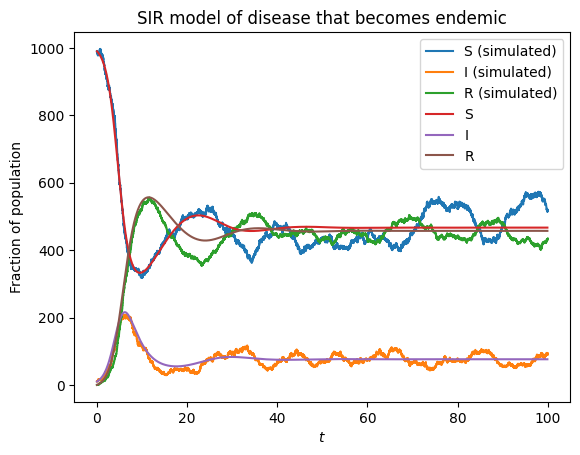

array([[0.00000000e+00, 1.34375846e-03, 9.90000000e+02, 1.00000000e+01,
        0.00000000e+00],
       [1.34375846e-03, 3.11153639e-04, 9.89000000e+02, 1.00000000e+01,
        0.00000000e+00],
       [1.65491210e-03, 1.83766437e-03, 9.88000000e+02, 1.00000000e+01,
        0.00000000e+00],
       ...,
       [9.99955915e+01, 5.97764634e-04, 5.17000000e+02, 9.10000000e+01,
        4.35000000e+02],
       [9.99961893e+01, 5.15515824e-03, 5.17000000e+02, 9.10000000e+01,
        4.34000000e+02],
       [1.00001344e+02, 0.00000000e+00, 5.16000000e+02, 9.10000000e+01,
        4.34000000e+02]])

In [6]:
t_start = 0
t_end = 100
initial_infection = 0.01
N = 1000
beta = 1.5
gamma = 0.6
mu = 0.1
# simulate((1 - initial_infection) * N, initial_infection * N, 0, beta, gamma, mu, t_end, ret_avg=True)
run_simulation_and_graph(t_start, t_end, initial_infection, N, beta, gamma, mu)

Note: We can reduce the variablity by increasing the number of people in the simulation.

## Investigate Simulation Variability and Negative Co-variance
To determine the variance between runs, we'll run every simulation 50 times, with different parameter values.

In [23]:
# First the beta
N = 1000
n_sim_runs = 2500
t_start = 0
t_end = 100
initial_infection = 0.04
beta = 1.6
gamma = 0.2
mu = 0.05

betas = np.arange(1.1, 2.0, 0.025)
beta_end_values = np.zeros((len(betas), n_sim_runs, 3))
beta_mean = np.zeros((len(betas), n_sim_runs, 3))
beta_cov = np.zeros((len(betas), n_sim_runs))

for i, _beta in enumerate(tqdm(betas)):
    for j in range(n_sim_runs):
        result_statistics = get_statistics(event_based_simulation((1 - initial_infection) * N, initial_infection*N, 0, _beta, gamma, mu, t_end), t_end)
        beta_mean[i, j] = result_statistics[0]
        beta_end_values[i, j] = result_statistics[1][2:]
        beta_cov[i, j] = result_statistics[2]

  0%|          | 0/36 [00:00<?, ?it/s]

To compare the variance between the simulations, we're comparing variance of the simulated results at t = T_max of the given beta's. We are simulating n = 1000 simulations for beta in [1.1, 2.0], where all it is simulated for every 0.01. We can clearly see that the variance of the R compartment increases, and the variance of the I compartment says rather similar. The variance of the S compartment decreases.

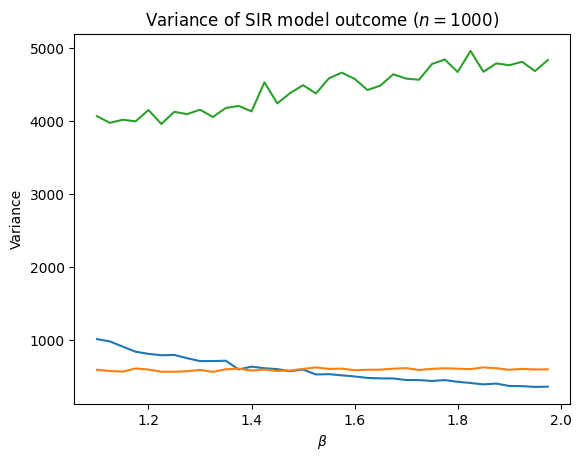

In [24]:
# res
def plot_variance_outcome(end_values: np.ndarray, param_values: np.ndarray, title: str, xlabel: str):
    res_var = end_values.var(axis=1)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Variance")
    plt.plot(param_values, res_var)
    plt.show()

plot_variance_outcome(beta_end_values, betas, "Variance of SIR model outcome ($n = 1000$)", "$\\beta$")

We can easily get the means of the simulations of the betas. We can clearly see that as beta increases, the disease spreads faster, thus there are less suseptibles and more that have recovered. 

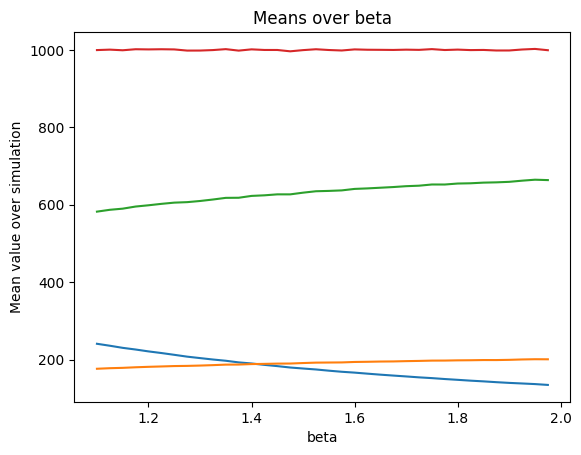

In [25]:
def plot_mean(mean_values: np.ndarray, param_values: np.ndarray, title: str, xlabel: str):
    res_avg_m = mean_values.mean(axis=1)
    plt.plot(param_values, res_avg_m)
    plt.plot(param_values, res_avg_m.sum(axis=1))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Mean value over simulation")
    plt.show()

plot_mean(beta_mean, betas, "Means over beta", "beta")

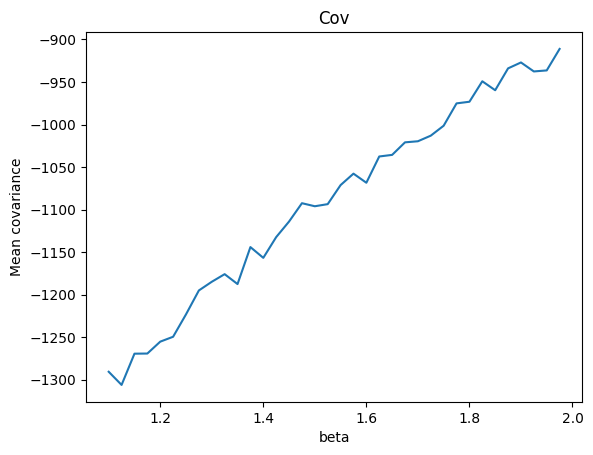

In [26]:
def plot_SI_cov(cov_values: np.ndarray, param_values: np.ndarray, title: str, xlabel: str):
    res_cov_m = cov_values.mean(axis=1)
    plt.plot(param_values, res_cov_m)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Mean covariance")
    plt.show()

plot_SI_cov(beta_cov, betas, "Cov", "beta")

In [ ]:
gammas = np.arange(0.1, 1.6, 0.05)
gamma_end_values = np.zeros((len(gammas), n_sim_runs, 3))
gamma_mean = np.zeros((len(gammas), n_sim_runs, 3))
gamma_cov = np.zeros((len(gammas), n_sim_runs))

for i, _gamma in enumerate(tqdm(gammas)):
    for j in range(n_sim_runs):
        result_statistics = get_statistics(event_based_simulation((1 - initial_infection) * N, initial_infection*N, 0, beta, _gamma, mu, t_end), t_end)
        gamma_mean[i, j] = result_statistics[0]
        gamma_end_values[i, j] = result_statistics[1][2:]
        gamma_cov[i, j] = result_statistics[2]

  0%|          | 0/60 [00:00<?, ?it/s]

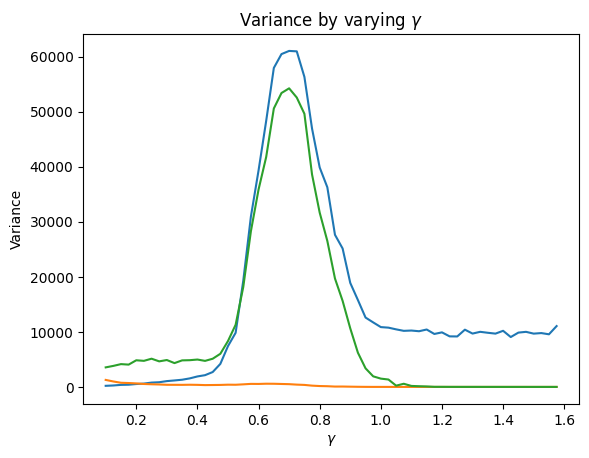

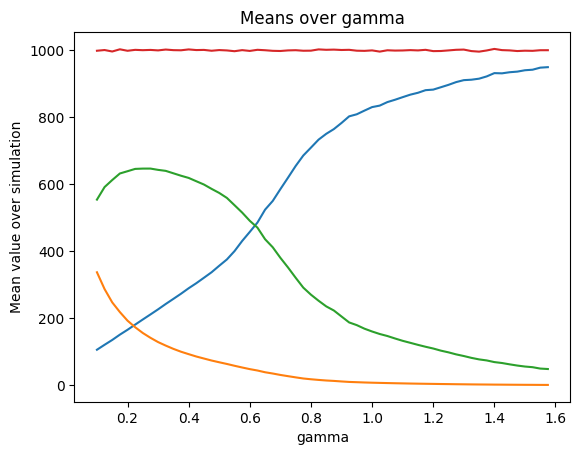

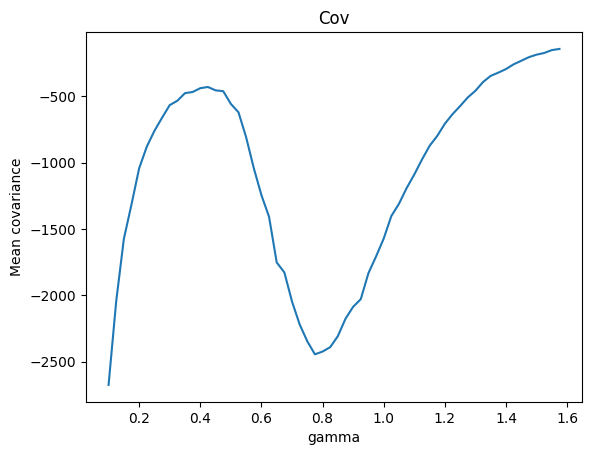

In [ ]:
plot_variance_outcome(gamma_end_values, gammas, "Variance by varying $\\gamma$", "$\\gamma$")
plot_mean(gamma_mean, gammas, "Means over gamma", "gamma")
plot_SI_cov(gamma_cov, gammas, "Cov", "gamma")

In [13]:
mus = np.arange(0.01, 0.2, 0.01)
n_sim_runs_mu = 10000
mu_end_values = np.zeros((len(mus), n_sim_runs_mu, 3))
mu_mean = np.zeros((len(mus), n_sim_runs_mu, 3))
mu_cov = np.zeros((len(mus), n_sim_runs_mu))

for i, _mu in enumerate(tqdm(mus)):
    for j in range(n_sim_runs_mu):
        result_statistics = get_statistics(event_based_simulation((1 - initial_infection) * N, initial_infection*N, 0, beta, gamma, _mu, t_end), t_end)
        mu_mean[i, j] = result_statistics[0]
        mu_end_values[i, j] = result_statistics[1][2:]
        mu_cov[i, j] = result_statistics[2]

  0%|          | 0/19 [00:00<?, ?it/s]

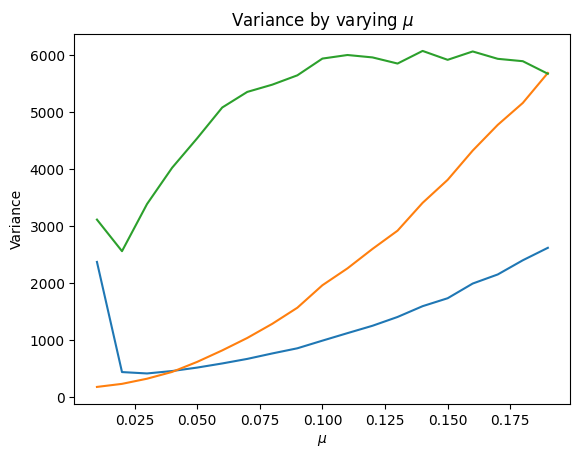

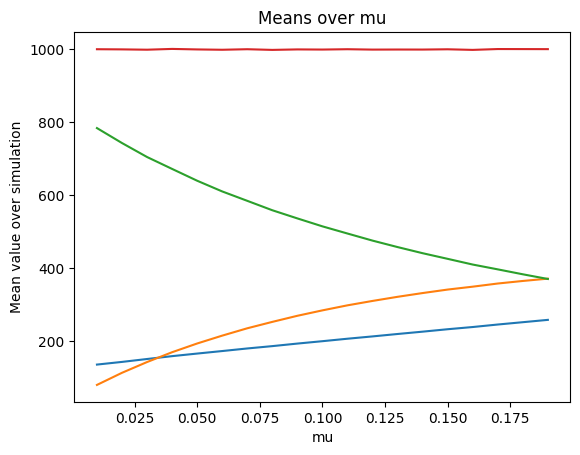

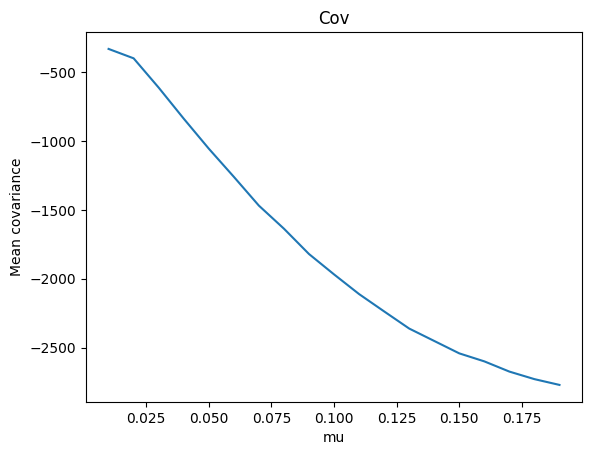

In [18]:
plot_variance_outcome(mu_end_values, mus, "Variance by varying $\\mu$", "$\\mu$")
plot_mean(mu_mean, mus, "Means over mu", "mu")
plot_SI_cov(mu_cov, mus, "Cov", "mu")

In [19]:
Ns = np.array([10, 25, 100, 250, 1000, 2500, 10000, 25000])
N_end_values = np.zeros((len(Ns), n_sim_runs, 3))
N_mean = np.zeros((len(Ns), n_sim_runs, 3))
N_cov = np.zeros((len(Ns), n_sim_runs))

for i, _N in enumerate(tqdm(Ns)):
    for j in range(n_sim_runs):
        result_statistics = get_statistics(event_based_simulation(np.ceil((1 - initial_infection) * _N), np.floor(initial_infection*_N), 0, beta, gamma, mu, t_end), t_end)
        N_mean[i, j] = result_statistics[0]
        N_end_values[i, j] = result_statistics[1][2:]
        N_cov[i, j] = result_statistics[2]

  0%|          | 0/8 [00:00<?, ?it/s]

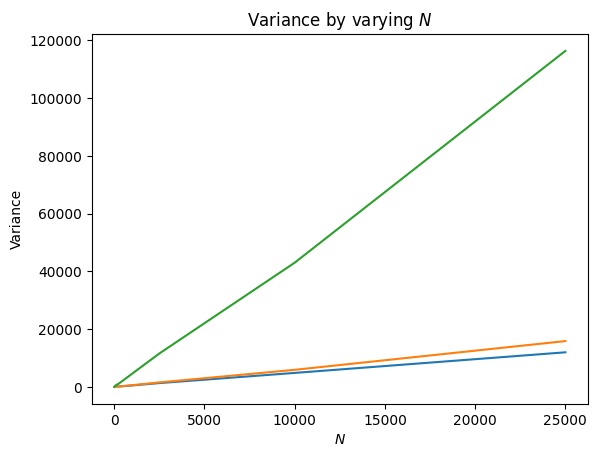

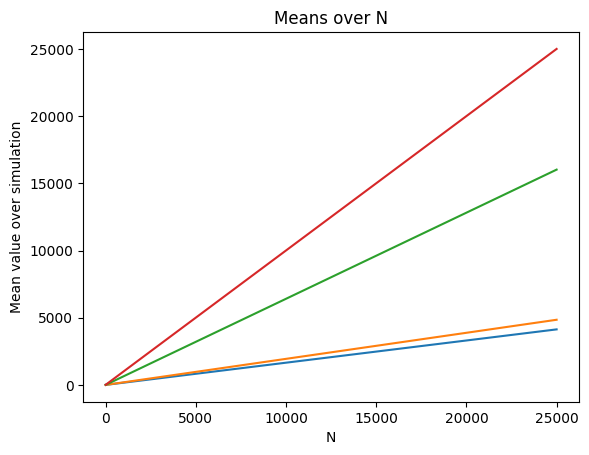

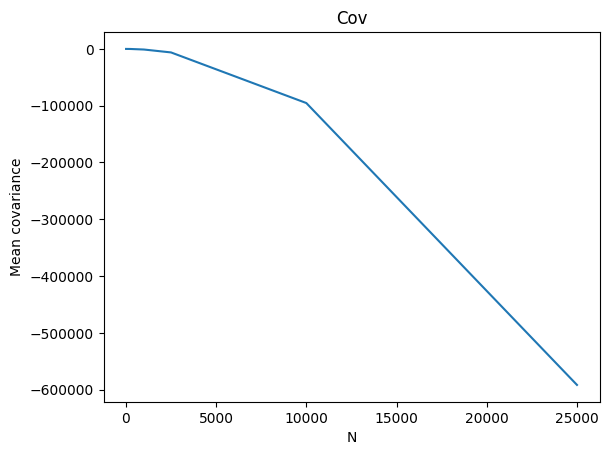

In [20]:
plot_variance_outcome(N_end_values, Ns, "Variance by varying $N$", "$N$")
plot_mean(N_mean, Ns, "Means over N", "N")
plot_SI_cov(N_cov, Ns, "Cov", "N")

Example of Stochastic resonance and transients. I believe that increased appears when Gamma is high, but am not yet sure. To measure transients, we start with the deterministic mean, and then look at the variance at that level. Note we do ignore extinction events, since that is not an example of transients.

In [88]:
def get_deterministic_mean(beta: float, gamma: float, mu: float, N: int, epsilon: float = 0.001):
    def sir_model(t: float, SIR: np.ndarray):
        S, I, R = SIR

        return np.array([
            mu - beta*S*I - mu * S,
            beta*S*I-gamma*I - mu * I,
            gamma*I - mu * R
        ])
    
    t_end = 5
    
    while True:
        integrated_sir = igr.solve_ivp(sir_model, [t_start, t_end], np.array([1-initial_infection, initial_infection, 0]), t_eval=np.arange(t_start, t_end, 0.1))
        provisional_deterministic_mean = integrated_sir.y[:, -1]
        prev_value = integrated_sir.y[:, -t_end]

        if (np.abs(provisional_deterministic_mean - prev_value)).sum() < epsilon:
            break
        else:
            t_end *= 2

    return np.rint(provisional_deterministic_mean * N).astype(int)

def get_transients(beta: float, gamma: float, mu: float, N: int, sim_iterations: int, T_max: float):
    inital_values = get_deterministic_mean(beta, gamma, mu, N)
    transients = np.zeros(sim_iterations)

    for i in range(sim_iterations):
        sus_line = event_based_simulation(inital_values[0], inital_values[1], inital_values[2], beta, gamma, mu, T_max)[:,3]
        transients[i] = np.var(sus_line)

    return transients.mean()

get_transients(1.5, 0.8, 0.1, 1000, 100, 100)

357.1871096392929

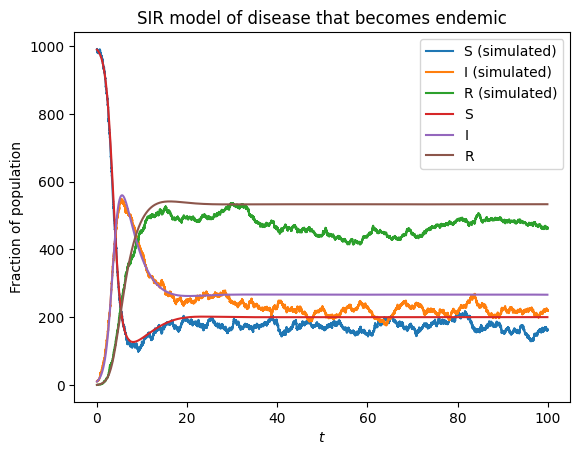

array([[0.00000000e+00, 2.94601184e-03, 9.90000000e+02, 1.00000000e+01,
        0.00000000e+00],
       [2.94601184e-03, 3.63414889e-03, 9.89000000e+02, 1.00000000e+01,
        0.00000000e+00],
       [6.58016073e-03, 2.32777788e-03, 9.88000000e+02, 1.00000000e+01,
        0.00000000e+00],
       ...,
       [9.99933632e+01, 5.46709244e-03, 1.63000000e+02, 2.20000000e+02,
        4.63000000e+02],
       [9.99988303e+01, 1.18785782e-03, 1.63000000e+02, 2.19000000e+02,
        4.63000000e+02],
       [1.00000018e+02, 0.00000000e+00, 1.63000000e+02, 2.19000000e+02,
        4.62000000e+02]])

In [81]:
t_start = 0
t_end = 100
initial_infection = 0.01
N = 1000
beta = 1.5
gamma = 0.2
mu = 0.1
run_simulation_and_graph(t_start, t_end, initial_infection, N, beta, gamma, mu)

## Extinction events
Two measurements, probability of extinction for T_max and time until extinction.

In [ ]:
def get_time_till_extinction(log_array: np.ndarray):
    display(np.argmin(log_array, axis=0))

get_time_till_extinction(event_based_simulation(1000, 0.01, 100, 1.5, 0.6, 0.05, 100))

  0%|          | 0/100 [00:00<?, ?it/s]

array([    0, 17461,  3678,     0,   625])

In [ ]:
def estimate_probabilities(t_end: int, initial_infection: float, N: int, beta: float, gamma: float, mu: float, n_sim: int):
    for i in trange(n_sim):
        event_based_simulation((1 - initial_infection) * N, initial_infection*N, 0, beta, gamma, mu, t_end, False)

estimate_probabilities(1000, 0.01, 100, 1.5, 0.6, 0.05, 100)

  0%|          | 0/100 [00:00<?, ?it/s]